# Simple demo of change of variables formula for normalizing flows

First we do some standard imports and setup a plotting functions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def show_samples_and_density(samples, density, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.distplot(samples, kde=False, rug=True, hist=True, norm_hist=True, ax=ax, label='Sample Hist.')
    xq = np.linspace(0.01, 2, num=1000)
    density_xq = density(xq)
    ax.plot(np.concatenate(([xq[0]],xq,[xq[-1]])), np.concatenate(([0],density(xq),[0])), label='True density')
    ax.legend()

## A simple generator $x = G(z) = 2z$ (this is trivial to invert)

If we assume the base distribution is uniform, i.e., $z\sim \text{Uniform}([0,1])$, what is the distribution of $p(x)$ based on the change of variables?

We will use transformations of samples to see the empirical distribution for intuition.

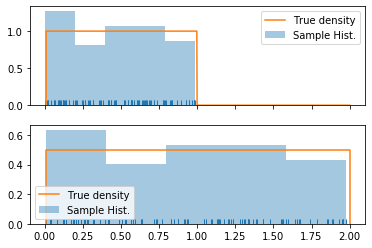

In [2]:
rng = np.random.RandomState(0)
n_samples = 100
Z = rng.rand(n_samples)
def G(Z):
    return 2*Z
def Ginv(X):
    return X/2
def dGinv(X):
    return 1/2
X = G(Z)

def pz(z):
    return np.ones_like(z) * np.logical_and(z >= 0, z <= 1)
def px(x):
    #return pz(x)
    #return 2*pz(x) #G(pz(x))
    #return 1/2*pz(x) #Ginv(pz(x))
    #return pz(2*x) #pz(G(x))
    #return pz(x/2) #pz(Ginv(x))
    #return 1/2*pz(x/2) #|dGinv(x)/dx| pz(Ginv(x))
    return dGinv(x)*pz(Ginv(x)) #|dGinv(x)/dx| pz(Ginv(x))
    
fig, axes = plt.subplots(2,1, figsize=(6, 4), sharex=True)
for samples, density, ax in zip([Z, X], [pz, px], axes.ravel()):
    show_samples_and_density(samples, density, ax)

Thus we see that $p(x)=p(G^{-1}(x))\left|\frac{dG^{-1}(x)}{dx}\right|$

Let's try another example with $x = G(z) = z/2$.

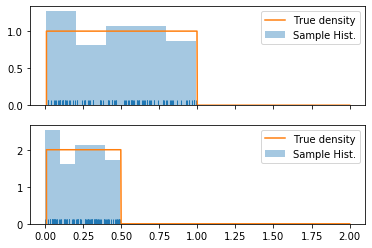

In [3]:
rng = np.random.RandomState(0)
n_samples = 100
Z = rng.rand(n_samples)
def G(Z):
    return Z/2
def Ginv(X):
    return 2*X
def dGinv(X):
    return 2
X = G(Z)

def pz(z):
    return np.ones_like(z) * np.logical_and(z >= 0, z <= 1)
def px(x):
    return dGinv(x)*pz(Ginv(x)) #|dGinv(x)/dx| pz(Ginv(x))
    
fig, axes = plt.subplots(2,1, figsize=(6, 4), sharex=True)
for samples, density, ax in zip([Z, X], [pz, px], axes.ravel()):
    show_samples_and_density(samples, density, ax)

## Example with $x = G(z) = z^2$ (which is invertible in the range $[0,1]$)

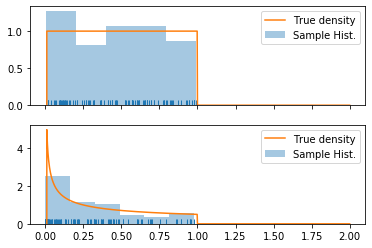

In [4]:
rng = np.random.RandomState(0)
n_samples = 100
Z = rng.rand(n_samples)
def G(Z):
    return Z**2
def Ginv(X):
    return np.sqrt(X)
def dGinv(X):
    return 1/2*X**(-1/2)
X = G(Z)

def pz(z):
    return np.ones_like(z) * np.logical_and(z >= 0, z <= 1)
def px(x):
    return dGinv(x)*pz(Ginv(x)) #|dGinv(x)/dx| pz(Ginv(x))
    
fig, axes = plt.subplots(2,1, figsize=(6, 4), sharex=True)
for samples, density, ax in zip([Z, X], [pz, px], axes.ravel()):
    show_samples_and_density(samples, density, ax)

## Let's use torch to automatically compute derivatives for us :-) 

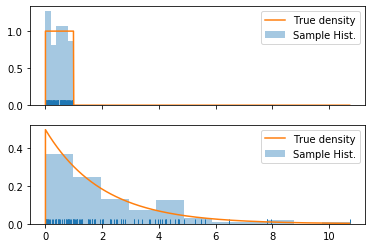

In [5]:
import torch
def torch_show_samples_and_density(samples, density, xlim=[0.01, 2], ax=None):
    if ax is None:
        ax = plt.gca()
    xq = torch.linspace(*xlim, 1000)
    density_xq = density(xq)
    # Convert to numpy to display
    sns.distplot(samples.detach().numpy(), kde=False, rug=True, hist=True, norm_hist=True, ax=ax, label='Sample Hist.')
    density_xq = density_xq.detach().numpy()
    xq = xq.detach().numpy()
    ax.plot(np.concatenate(([xq[0]],xq,[xq[-1]])), np.concatenate(([0],density_xq,[0])), label='True density')
    ax.legend()
    
rng = np.random.RandomState(0)
n_samples = 100
Z = rng.rand(n_samples)
Z = torch.from_numpy(Z)

def G(Z):
    #return Z**2
    return -torch.log(Z**2)
def Ginv(X):
    #return torch.sqrt(X)
    return torch.sqrt(torch.exp(-X))
X = G(Z)

def pz(z):
    return torch.ones_like(z) * (z >= 0).float() * (z <= 1).float()
def px(x):
    x.requires_grad_(True)
    z = Ginv(x)
    sum_z = torch.sum(z)
    sum_z.backward()
    with torch.no_grad():
        #return x.grad * pz(Ginv(x))  #|dGinv(x)/dx| pz(Ginv(x))
        return torch.abs(x.grad) * pz(Ginv(x))  #|dGinv(x)/dx| pz(Ginv(x))
    
fig, axes = plt.subplots(2,1, figsize=(6, 4), sharex=True)
for samples, density, ax in zip([Z, X], [pz, px], axes.ravel()):
    torch_show_samples_and_density(samples, density, xlim=[0.01, torch.max(X)], ax=ax)

# 2D example flow via an invertible linear transformation $x = G(z) = Az$

Note that $\left|\frac{dG^{-1}(x)}{dx}\right|=|J_{G^{-1}}(x)| = |A^{-1}|$, since $G^{-1}(x) = A^{-1}x$ and the Jacobian of a matrix multiplication is just the matrix itself, i.e., $A^{-1}$ in this case.

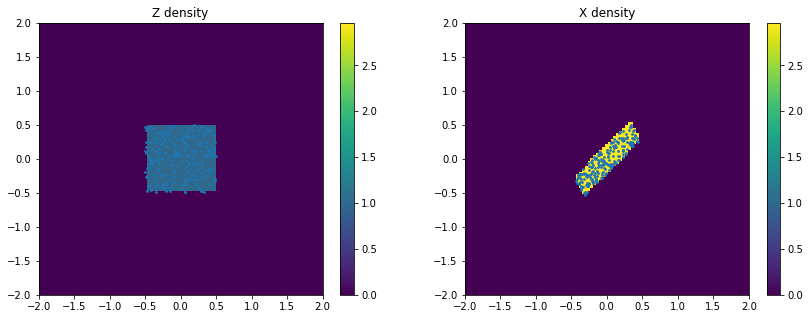

In [6]:
rng = np.random.RandomState(1)
n_samples = 200
Z = rng.rand(n_samples,2)-0.5
A = np.linalg.qr(rng.randn(2,2))[0] # Orthogonal A (i.e., just a rotation or reflection)
A = rng.randn(2,2) # A general linear transformation
Ainv = np.linalg.inv(A)
maxV = np.maximum(np.linalg.det(Ainv), 1)

def G(Z):
    return np.dot(A, Z.T).T
def Ginv(X):
    return np.dot(Ainv, X.T).T
X = G(Z)

def pz(z):
    # Uniform distribution
    return np.ones_like(z.shape[0]) * np.prod(np.logical_and(z >= -0.5, z <= 0.5), axis=1)
def px(x):
    return np.abs(np.linalg.det(Ainv)) * pz(Ginv(x)) #|dGinv(x)/dx| pz(Ginv(x))

def show_samples_and_density_2d(samples, density, xlim=[-2, 2], ylim=[-2, 2], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    #joint_grid = sns.jointplot(x=samples[:,0], y=samples[:,1], label='Sample Hist.', xlim=xlim, ylim=ylim, **kwargs)
    xx, yy = np.meshgrid(np.linspace(*xlim, 100), np.linspace(*ylim, 100))
    density_zz = density(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)
    pc = ax.pcolormesh(xx, yy, density_zz, alpha=1, vmin=0, vmax=maxV, label='True density')
    fig.colorbar(pc, ax=ax)
    ax.scatter(*samples.T, s=3, label='Scatter Plot')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True)
for samples, density, title, ax in zip([Z, X], [pz, px], ['Z density','X density'], axes.ravel()):
    show_samples_and_density_2d(samples, density, ax=ax)
    ax.set_title(title)